### This notebook demonstrates the experiments conducted using a perceptual loss function realized through a pre-trained VGG network.

Experiments 1-4 were conducted on the old upsampling code that suffered from a bug that provided the network with wrong input subsamples. This resulted in a much lower PSNR.

It was later rectified and the experiments 5 and 6 demonstrate the high PSNR that was achieved using VGG loss. 

Due to the lack of time, we were not able to conduct the initial experiments using the corrected upsamples. However, we feel that the relative results and improvements seen for the different experiments would still hold true.

In [1]:
%autoreload 2
%reload_ext autoreload
from __future__ import print_function
import theano
import theano.tensor as T
import numpy as np
import SRCNN_VGG_Theano
import os
import preprocessing
from scipy import ndimage,misc
import matplotlib.pyplot as plt
%matplotlib inline

ERROR:root:Line magic function `%autoreload` not found.
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5105)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
theano.config.device

'gpu'

In [2]:
#Create Validation_Subsamples_RGB_4 and Validation_Subsamples_RGB_4_GT folders
preprocessing.create_subimages('/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Set5',                               
'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Validation_Subsamples_RGB_4',
output_type ='RGB',upsampling_factor = 4)

preprocessing.create_subimages('/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Set14',
'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4',
output_type ='RGB',upsampling_factor = 4)

preprocessing.create_subimages('/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Training_Full',
'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Training_Subsamples_RGB_4',
output_type ='RGB',upsampling_factor = 4)


here
creating
creating
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Set5
processed:0
mapping file:  /Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Validation_Subsamples_RGB_4mapping
here
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Set14
processed:0
processed:10
mapping file:  /Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4mapping
here
creating
creating
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Training_Full
processed:0
processed:10
processed:20
processed:30
processed:40
processed:50
processed:60
processed:70
processed:80
processed:90
mapping file:  /Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Training_Subsamples_RGB_4mapping


In [3]:
#load dataset

#load training
data_x = SRCNN_VGG_Theano.load_dataset('Data/Training_Subsamples_RGB_4','data_x')
data_y = SRCNN_VGG_Theano.load_dataset('Data/Training_Subsamples_RGB_4_gt','data_y')
valid_x = SRCNN_VGG_Theano.load_dataset('Data/Validation_Subsamples_RGB_4','data_x')
valid_y = SRCNN_VGG_Theano.load_dataset('Data/Validation_Subsamples_RGB_4_gt','data_y')
test_x = SRCNN_VGG_Theano.load_dataset('Data/Test_Subsamples_RGB_4','data_x')
test_y = SRCNN_VGG_Theano.load_dataset('Data/Test_Subsamples_RGB_4_gt','data_y')
print("done loading\n\n")
print("data_x: " + str(data_x.shape))
print("data_y: " + str(data_y.shape))
print("valid_x: " + str(valid_x.shape))
print("valid_y: " + str(valid_y.shape))
print("test_x: " + str(test_x.shape))
print("test_y: " + str(test_y.shape))

/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Training_Subsamples_RGB_4
creating npz file
Valid!
141.0
141.0
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Training_Subsamples_RGB_4_gt
creating npz file
Valid!
137.0
137.0
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Validation_Subsamples_RGB_4
creating npz file
Valid!
251.0
251.0
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Validation_Subsamples_RGB_4_gt
creating npz file
Valid!
251.0
251.0
/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/pr

In [4]:
#Bicubic interp to save computation during training
upsampled_x = preprocessing.upsample(data_x) #33,33,3 input images expected
up_val_x = preprocessing.upsample(valid_x) #33,33,3 input images expected
up_test_x = preprocessing.upsample(test_x) #33,33,3 input images expected

#Reshape for training,valid,test
upsampled_x = upsampled_x.reshape((22092,33*33*3))
data_y = data_y.reshape((22092,33*33*3))
up_val_x = up_val_x.reshape((2488,33*33*3))
valid_y = valid_y.reshape((2488,33*33*3))
up_test_x = up_test_x.reshape((14851,33*33*3))
test_y = test_y.reshape((14851,33*33*3))

print(upsampled_x.shape)
print(data_y.shape)
print(up_val_x.shape)
print(up_test_x.shape)

(22092, 3267)
(22092, 3267)
(2488, 3267)
(14851, 3267)


In [18]:
shared_x = theano.shared(np.asarray(upsampled_x,dtype=theano.config.floatX),borrow=True)
shared_y =  theano.shared(np.asarray(data_y,dtype=theano.config.floatX),borrow=True)
shared_val_x = theano.shared(np.asarray(up_val_x,dtype=theano.config.floatX),borrow=True)
shared_val_y = theano.shared(np.asarray(valid_y,dtype=theano.config.floatX),borrow=True)
shared_test_x =theano.shared(np.asarray(up_test_x,dtype=theano.config.floatX),borrow=True)
shared_test_y =theano.shared(np.asarray(test_y,dtype=theano.config.floatX),borrow=True)

In [5]:
#IF OUT OF MEMORY!!!
#shared_x = theano.tensor._shared(np.asarray(upsampled_x,dtype=theano.config.floatX),borrow=True)
#shared_y =  theano.tensor._shared(np.asarray(data_y,dtype=theano.config.floatX),borrow=True)
#shared_val_x = theano.tensor._shared(np.asarray(up_val_x,dtype=theano.config.floatX),borrow=True)
#shared_val_y = theano.tensor._shared(np.asarray(valid_y,dtype=theano.config.floatX),borrow=True)
#shared_test_x =theano.tensor._shared(np.asarray(up_test_x,dtype=theano.config.floatX),borrow=True)
#shared_test_y =theano.tensor._shared(np.asarray(test_y,dtype=theano.config.floatX),borrow=True)

### Experiment 1- Using only the VGG loss

In [7]:
batch_size = 100
n_epochs = 20
lrs = [.0001]#,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
for lr in lrs:
    print("\n\n ****************************** lr = " + str(lr) +"******************************************")
    learning_rate = lr

    n_train_batches = int(upsampled_x.shape[0]/batch_size)
    n_valid_batches = int(up_val_x.shape[0]/batch_size)
    n_test_batches = int(up_test_x.shape[0]/batch_size)


    train_model,val_model,test_model = SRCNN_VGG_Theano.train_SRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer:  fast_compile
... building the vgg model for low resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
... building the vgg model for high resolution input
im_dims= [33 33]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
Training...
epoch 1, minibatch 220/220, validation cost 755.277100 mse/pixel:

In [8]:
reconstructed_imgs = np.zeros((14851, 3, 21, 21))
for i in range(n_test_batches):
     cost,MSE_per_pixel,psnr,psnr_orig,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches
    
#reconstructed_imgs[:,0,:,:]+=-103.939
#reconstructed_imgs[:,0,:,:]+=-116.779
#reconstructed_imgs[:,0,:,:]+=-123.68

SRCNN_VGG_Theano.rebuild_images(reconstructed_imgs,'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test')
        

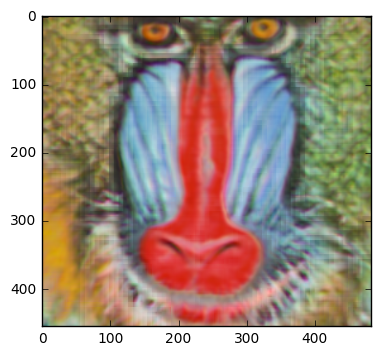

In [9]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/baboon.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

### Experiment 2 - Loss is the sum of losses in VGG domain and original domain

In [6]:
batch_size = 100
n_epochs = 20
lrs = [.0001]#,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
for lr in lrs:
    print("\n\n ****************************** lr = " + str(lr) +"******************************************")
    learning_rate = lr

    n_train_batches = int(upsampled_x.shape[0]/batch_size)
    n_valid_batches = int(up_val_x.shape[0]/batch_size)
    n_test_batches = int(up_test_x.shape[0]/batch_size)


    train_model,val_model,test_model = SRCNN_VGG_Theano.train_SRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer:  fast_compile
... building the vgg model for low resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
... building the vgg model for high resolution input
im_dims= [33 33]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
Training...
epoch 1, minibatch 220/220, validation cost 2581.609375 mse/pixel

In [7]:
reconstructed_imgs = np.zeros((14851, 3, 21, 21))
for i in range(n_test_batches):
     cost,MSE_per_pixel,psnr,psnr_orig,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

SRCNN_VGG_Theano.rebuild_images(reconstructed_imgs,'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test')
        

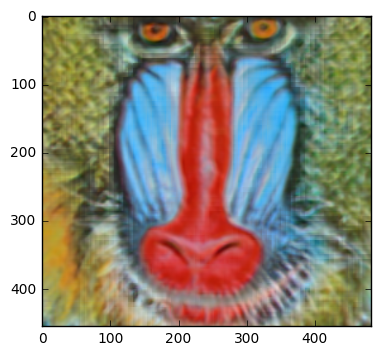

In [8]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/baboon.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

### Experiment 3 - Same as above, running for larger number of epochs

In [9]:
batch_size = 100
n_epochs = 50
lrs = [.0001]#,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
for lr in lrs:
    print("\n\n ****************************** lr = " + str(lr) +"******************************************")
    learning_rate = lr

    n_train_batches = int(upsampled_x.shape[0]/batch_size)
    n_valid_batches = int(up_val_x.shape[0]/batch_size)
    n_test_batches = int(up_test_x.shape[0]/batch_size)


    train_model,val_model,test_model = SRCNN_VGG_Theano.train_SRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer:  fast_compile
... building the vgg model for low resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
... building the vgg model for high resolution input
im_dims= [33 33]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
Training...
epoch 1, minibatch 220/220, validation cost 2706.219238 mse/pixel

In [10]:
reconstructed_imgs = np.zeros((14851, 3, 21, 21))
for i in range(n_test_batches):
     cost,MSE_per_pixel,psnr,psnr_orig,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

SRCNN_VGG_Theano.rebuild_images(reconstructed_imgs,'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test')
        

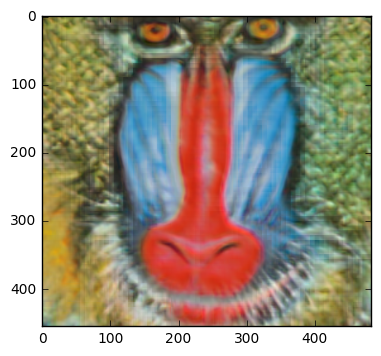

In [11]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/baboon.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

### Experiment 4- Using a learning rate for last conv layer in SRCNN, cropped 21x21 high resolution input to VGG

In [11]:
batch_size = 100
n_epochs = 20
lrs = [.0001]#,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
for lr in lrs:
    print("\n\n ****************************** lr = " + str(lr) +"******************************************")
    learning_rate = lr

    n_train_batches = int(upsampled_x.shape[0]/batch_size)
    n_valid_batches = int(up_val_x.shape[0]/batch_size)
    n_test_batches = int(up_test_x.shape[0]/batch_size)

    l2=0.0


    train_model,val_model,test_model = SRCNN_VGG_Theano.train_SRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer:  fast_compile
... building the vgg model for low resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
... building the vgg model for high resolution input
im_dims= [33 33]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
Training...
epoch 1, minibatch 220/220, validation cost 2690.419189 mse/pixel

In [12]:
reconstructed_imgs = np.zeros((14851, 3, 21, 21))
for i in range(n_test_batches):
     cost,MSE_per_pixel,psnr,psnr_orig,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

SRCNN_VGG_Theano.rebuild_images(reconstructed_imgs,'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test')
   

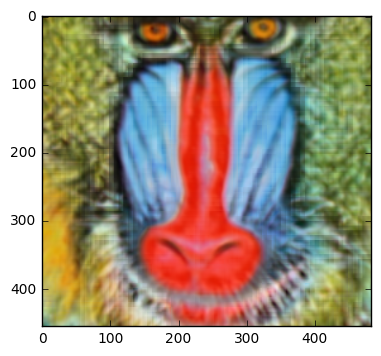

In [13]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/baboon.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

### Experiment 5- Using the corrected upsampling code

In [10]:
batch_size = 100
n_epochs = 20
lrs = [.0001]#,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
for lr in lrs:
    print("\n\n ****************************** lr = " + str(lr) +"******************************************")
    learning_rate = lr

    n_train_batches = int(upsampled_x.shape[0]/batch_size)
    n_valid_batches = int(up_val_x.shape[0]/batch_size)
    n_test_batches = int(up_test_x.shape[0]/batch_size)

    l2=0.0


    train_model,val_model,test_model = SRCNN_VGG_Theano.train_SRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer:  fast_compile
... building the vgg model for low resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
... building the vgg model for high resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
Training...
epoch 1, minibatch 220/220, validation cost 111.366371 mse/pixel:

In [11]:
reconstructed_imgs = np.zeros((14851, 3, 21, 21))
for i in range(n_test_batches):
     cost,MSE_per_pixel,psnr,psnr_orig,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

SRCNN_VGG_Theano.rebuild_images(reconstructed_imgs,'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test')
   

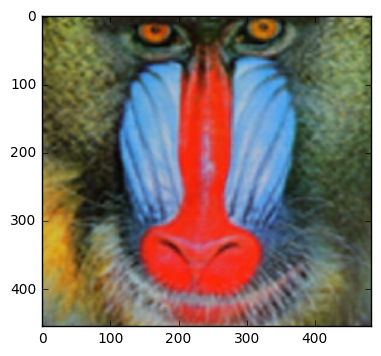

In [12]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/baboon.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

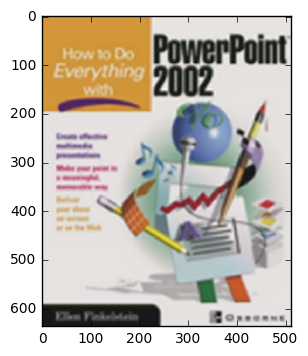

In [13]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/ppt3.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

### Experiment 6: Same as above, running for more epochs 

In [14]:
batch_size = 100
n_epochs = 40
lrs = [.0001]#,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
for lr in lrs:
    print("\n\n ****************************** lr = " + str(lr) +"******************************************")
    learning_rate = lr

    n_train_batches = int(upsampled_x.shape[0]/batch_size)
    n_valid_batches = int(up_val_x.shape[0]/batch_size)
    n_test_batches = int(up_test_x.shape[0]/batch_size)

    l2=0.0


    train_model,val_model,test_model = SRCNN_VGG_Theano.train_SRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer:  fast_compile
... building the vgg model for low resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
... building the vgg model for high resolution input
im_dims= [21 21]
Loading weights for Layer:  1
Weights loaded with dims:  (64, 3, 3, 3) and (64,)
Loading weights for Layer:  2
Weights loaded with dims:  (64, 64, 3, 3) and (64,)
Loading weights for Layer:  3
Weights loaded with dims:  (128, 64, 3, 3) and (128,)
Loading weights for Layer:  4
Weights loaded with dims:  (128, 128, 3, 3) and (128,)
Training...
epoch 1, minibatch 220/220, validation cost 149.938782 mse/pixel:

In [15]:
reconstructed_imgs = np.zeros((14851, 3, 21, 21))
for i in range(n_test_batches):
     cost,MSE_per_pixel,psnr,psnr_orig,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

SRCNN_VGG_Theano.rebuild_images(reconstructed_imgs,'/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test')
   

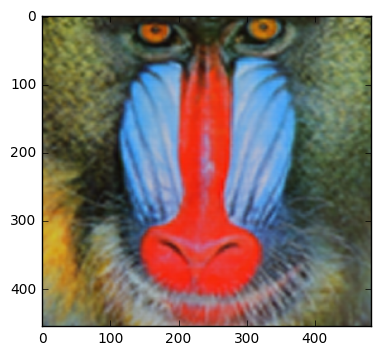

In [17]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/baboon.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

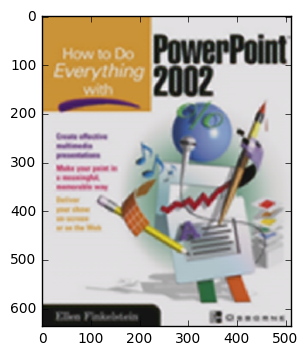

In [16]:
display_img_path = '/Users/himaniarora/Desktop/Columbia/Courses/Neural_networks/project/SRCNN/project/src/recon_imgs_test/ppt3.bmp'
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)